# Genotyping structural variants from sequencing data with vg

In this notebook, we play with a small toy dataset, extracted from real data, to review the workflow to genotype structural variants using pangenomes. It uses the [vg tookit](https://github.com/vgteam/vg).

This approach was introduced in [Hickey, Heller, Monlong, et al. (Genome Biology 2020)](https://doi.org/10.1186/s13059-020-1941-7).
This workflow was also used in the follow-up article [Sirén, Monlong, Chang, Novak, Eizenga, et al. (Science 2021)](https://doi.org/10.1126/science.abg8871) which introduced a faster read-mapping algorithm and demonstrated its value on a large-scale SV genotyping study.


In [1]:
# used to display image file in this notebook
from IPython.display import Image

## Test data

To test genotyping structural variants (SVs) with pangenome, we will work on a (tiny) genomic region that harbor an insertion and a deletion in the widely studied HG002 sample.

The region is about 7.8 Kbp. Its coordinates are `7:158876691-158884496` on the GRCh37/hg19 genome. The reference sequence was saved into a FASTA file (`ref.fa`). You can view this region in [the UCSC Genome Browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&&position=chr7%3A158876691-158884496) and notice that it contains simple tandem repeats.

We also prepared the SVs to genotype in a VCF file (`svs.vcf`). This is just a slice of the original SVs "truthset" created for this sample by the [Genome in a Bottle consortium](https://www.nist.gov/programs-projects/genome-bottle) and downloadable [here](https://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/release/AshkenazimTrio/HG002_NA24385_son/NIST_SV_v0.6/). Similarly, sequencing reads for this sample and originating from this region were prepared in the `reads.fastq.gz` file (gzipped FASTQ).

We can look at the first rows of each file, to get a feel for the data.

The reference sequence extracted from GRCh38:

In [2]:
!head svgenotyping_data/ref.fa

>ref
CAGCTTCCCAGCCCACTTCAGCCCCCATCACACACATCTCCGTCTGGGAAACTGCTTCTT
CCAGACCCTTTGTGTAATGATGAACGTCTTAACCAATGCCACTTTGCACAGGGTGCTGTG
GGGTGCAGAAAGCAAAGCCGCATCAGTACTCAGACAGCTTCTGTCCGGTCCTTAGTAAAC
AAGACCAACGCGCACCAGGCCAGAGGGGCAAAGGCCATGCCTCTGAGTTCTGCAGGCAGG
CAGTGGACTCTTGGCAGGCCGCACGAGGTGTGGGCGGGAGGATGAGAGTGCTCGGGGCAG
GAACTCTGGGAGCACTTAGTGGGTGAAGGGAAATAGCGAGTGATGGGGCAGGCGGCTGGG
CACGCTGGAGGGCAGTGCCGCCAGGTGAGACAGGAACAGCGTGAGGCAGGAGACAGGATG
TGGGGGCCCCTGGCGCAGCATTTCATGCCGAGTGACAGCACCCTCCCTTGGCCTCTTCCT
CCCAGAGTGGCACAATGTGTCCCCTGTTCCCTCTGCCAGGCTTCAGGCTCCTGCAGAGAG


Note: the contig is named `ref`.

The known structural variants from GIAB, represented in the VCF format:

In [3]:
!cat svgenotyping_data/svs.vcf

##fileformat=VCFv4.2
##fileDate=20240128
##reference=GRCh37
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=NoConsensusGT,Description="No individual had genotypes from svviz agree across all datasets with confident genotypes">
##FILTER=<ID=LongReadHomRef,Description="Long reads supported homozygous reference for all individuals">
##FILTER=<ID=ClusteredCalls,Description="Supported SVs that are within 1kb of a different supported SV">
##FILTER=<ID=lt50bp,Description="Supported variant but smaller than 50bp">
##contig=<ID=1,length=249250621>
##contig=<ID=2,length=243199373>
##contig=<ID=3,length=198022430>
##contig=<ID=4,length=191154276>
##contig=<ID=5,length=180915260>
##contig=<ID=6,length=171115067>
##contig=<ID=7,length=159138663>
##contig=<ID=8,length=146364022>
##contig=<ID=9,length=141213431>
##contig=<ID=10,length=135534747>
##contig=<ID=11,length=135006516>
##contig=<ID=12,length=133851895>
##contig=<ID=13,length=115169878>
##contig=<ID=14,length=107349540>
##co

The sequencing reads in FASTQ format:

In [4]:
!zcat svgenotyping_data/reads.fastq.gz | head -8

@A00744:46:HV3C3DSXX:2:1101:12789:11616
CTATCGCAAGGAGAAAAAACCAAACACCGCATGTTCTCACTCATAGGTGGGAATTGAACAATGAGAACACATGGACACAGGAAGGGGAACATCACACACCGGGGACTGTTGTGGGGTGGTGGGGTCGTGGGGGAGGGATAGCATTAGGAGA
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFF:FFFFFFF
@A00744:46:HV3C3DSXX:2:1101:12789:11616
TTAGAAACCCAAAGGAAATGGGCGAACAGGTAATTAGGATGAATTCAGAATGCTGCTCTCTCATAGAAACATTCTTTTTTTTATTATACTTTAAGTTTTAGGGTACATGTGCACAACGTGCAGGTTTGTTACATATGTATACATGTGCCAT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFF:FFFFF:FFFFFFFFFFFFFFFFFFFF

gzip: stdout: Broken pipe


## Build a pangenome from a reference sequence and variant information

A pangenome can be build by specifying variants relative to a reference genome. In practice, the reference sequence is stored in a FASTA file and the variants in a VCF file.

The pangenome *construct*ion command below reads that reference FASTA (`-r`) and variant VCF file (`-v`) to create a pangenome file (`.vg`).

In [5]:
!vg construct -r svgenotyping_data/ref.fa -v svgenotyping_data/svs.vcf -a -m 1024 > pan.vg

index file svgenotyping_data/ref.fa.fai not found, generating...


Some information about the other parameters (more information available by running `vg construct`):
- `-a` asks to save the information of the variants as "alternate" paths (see visualization below) which is necessary for variant genotyping later.
- `-m` specifies the maximum size for nodes. Even if there are no variants, nodes will be broken up, here every 1024 bases, to help computations and visualization. (more than 1024 is usually not advisable).


What is the pangenome made of? How many nodes, edges, bases?

In [6]:
!vg stats -zl pan.vg

nodes	10
edges	11
length	8451


We can also make a static image representing the pangenome. This works only for small graphs.

In [7]:
!vg view -dpS pan.vg | dot -Tpng -o pan.png

- `-d` means that we want to make a "dot" graph representation (that is then piped to `dot` to make the image file).
- `-p` means that we want to show paths through the graph, i.e. the reference path and the variant/alternate paths.
- `-S` means that we want a simplified representation, replacing the genomic sequence in each node by their length.

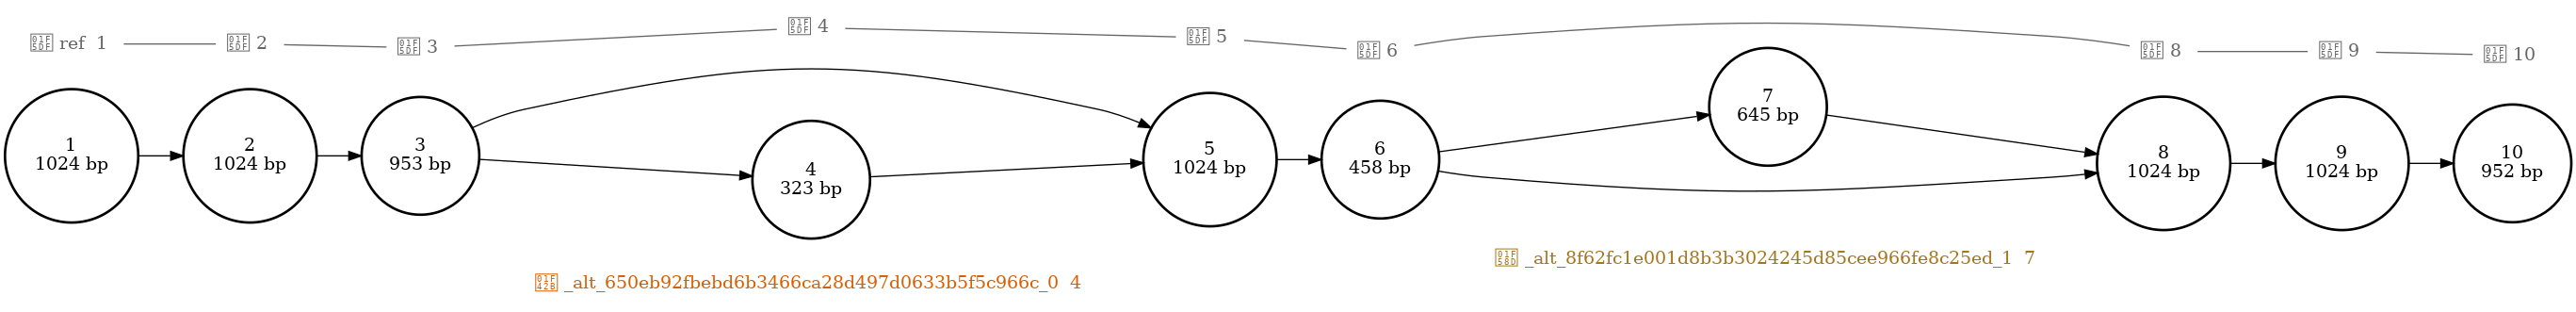

In [8]:
Image(filename='pan.png') 

The graph shows nodes (*circles*) connected by edges. We notice two "bubbles" in the middle, marked by the "_alt*" paths. These are the two variants defined in the input VCF. The "ref" path shows how to traverse the pangenome to get the reference genome. 

## Map sequencing reads to the pangenome

For DNA sequencing, the appropriate read mapping module in vg is called Giraffe. It's as fast as bwa-mem, one of the most used mapper for linear genomes.

To improve efficiency and accuracy, vg giraffe uses haplotype information. In the pangenome, haplotypes are represented as paths, like for the reference genome. If we don't have haplotype information available, vg can create artificial haplotypes that cover as many nodes as possible. Here, we will use this approach and **request four artificial haplotypes**.

In [9]:
!vg gbwt -x pan.vg --gbz-format -g pan.gbz --pass-paths -P -n 4

- `-x` to provide the pangenome
- `--gbz-format` to specify that we want the latest pangenome format, GBZ.
- `-g` to specify the name of the output file
- `-P` to specify that we want a set of artificial paths
- `-n` to specify how many paths we want to create

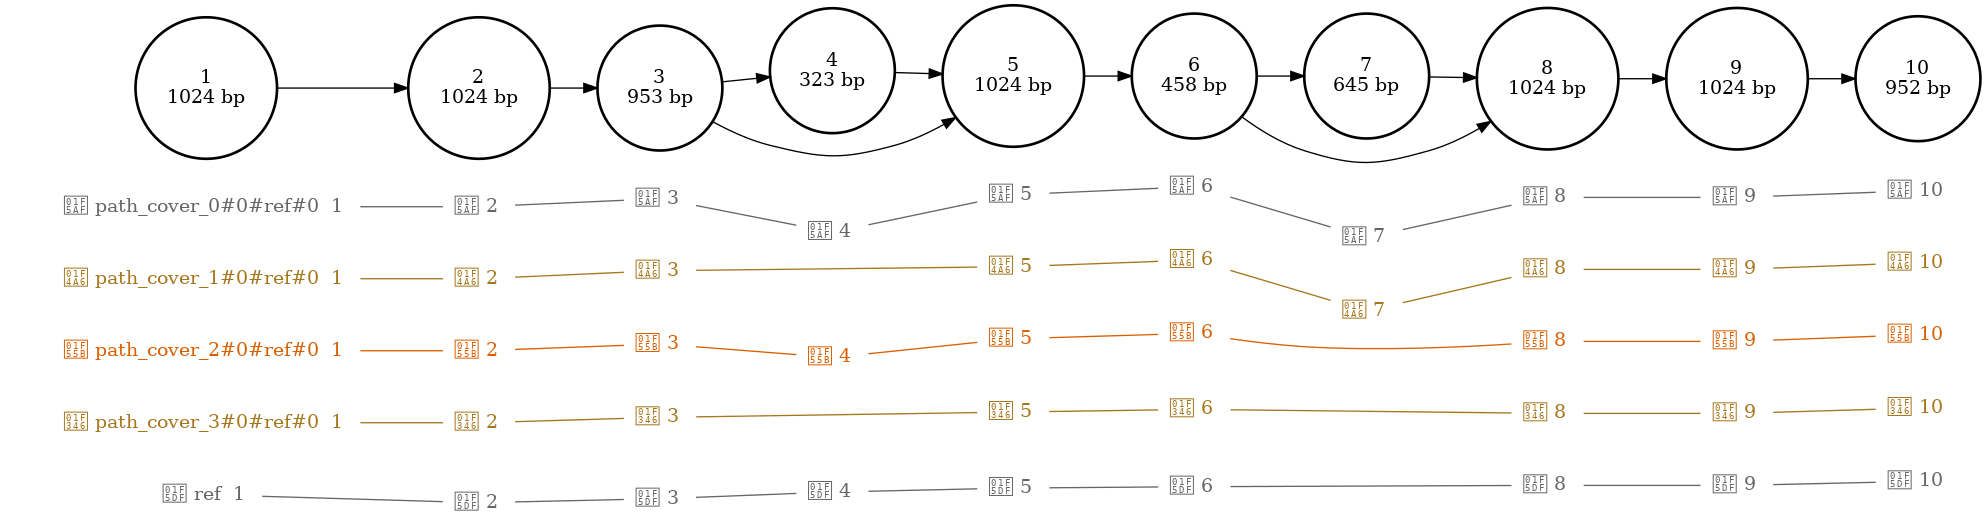

In [10]:
!vg view -dpS pan.gbz | dot -Tpng -o pan.gbz.png
Image(filename='pan.gbz.png') 

Other indexes are used by vg giraffe to speed up read mapping. In particular, the minimizer index stores the location of short sequences in the pangenome which help enumerate "seeds" for read mapping. The distance index precomputes and organize distances in the pangenome which speeds up clustering seeds. 

To make sure we are starting from scratch, we can remove those indexes and let giraffe recompute them. If we have changed the pangenome without recreating the indexes, we might get a bug. If the pangenome hasn't changed since the last time we ran giraffe, this step is not necessary because the indexes are still valid.

In [11]:
!rm -f pan.min pan.dist

In [12]:
!vg giraffe -Z pan.gbz -i -f svgenotyping_data/reads.fastq.gz -o gaf | gzip > reads.gaf.gz

[IndexRegistry]: Constructing distance index for Giraffe.
[IndexRegistry]: Constructing minimizer index.
warning[vg::giraffe]: Finalizing fragment length distribution before reaching maximum sample size
                      mapped 441 reads single ended with 2617 pairs of reads left unmapped
                      mean: 0, stdev: 1
warning[vg::giraffe]: Cannot cluster reads with a fragment distance smaller than read distance
                      Fragment length distribution: mean=0, stdev=1
                      Fragment distance limit: 2, read distance limit: 201
warning[vg::giraffe]: Falling back on single-end mapping


Note: The warning messages above are due to the fact that we are working with a very small toy dataset and there is not enough reads to, for example, figure out what is the distribution of the fragment length.

## Genotype variants

Once the reads are mapped, the variant genotyping is run in two steps:

1. Computation of the read coverage of each node and edges in the graph
2. Genotyping of the original variants based on this coverage.

The following commands creates a "pack" file that records read coverage on the pangenome.

In [13]:
!vg pack -x pan.vg -o reads.pack -a reads.gaf.gz

We provide the pangenome (`-x`) and the aligned reads (`-a`), and specify to create a pack file (`-o`).

With this coverage pack file (`-k`), we genotype the original variants by providing again the input VCF (`-v`)

In [14]:
!vg call -k reads.pack -v svgenotyping_data/svs.vcf pan.vg > calls.vcf

The output VCF has now a predicted genotype for each input variant

In [15]:
!cat calls.vcf

##fileformat=VCFv4.2
##contig=<ID=ref,length=0>
##INFO=<ID=AT,Number=R,Type=String,Description="Allele Traversal as path in graph">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=MAD,Number=1,Type=Integer,Description="Minimum site allele depth">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
##FORMAT=<ID=GL,Number=G,Type=Float,Description="Genotype Likelihood, log10-scaled likelihoods of the data given the called genotype for each possible genotype generated from the reference and alternate alleles given the sample ploidy">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality, the Phred-scaled probability estimate of the called genotype">
##FORMAT=<ID=GP,Number=1,Type=Float,Description="Genotype Probability, the log-scaled posterior probability of the 

Were all the SVs properly genotyped? I.e. were they predicted to be present in this sample, like we expect?

## Pangenome from aligning assemblies

Let's repeat the analysis, but this time **build the pangenome by aligning genome assemblies** of this region in the sample of interest. 

Indeed, HG002 now has a high quality phased assembly which were produced by the [T2T consortium](https://sites.google.com/ucsc.edu/t2tworkinggroup). The `mat.fa` and `pat.fa` corresponds to the region of interest in the maternal and paternal haplotype of HG002. 

In practice, we recommend using dedicated tools to build a pangenome from whole-genome assemblies, specifically [Minigraph-Cactus](https://github.com/ComparativeGenomicsToolkit/cactus/blob/master/doc/pangenome.md) or [PGGB](https://github.com/pangenome/pggb). Here, we will use an old (deprecated) function from vg to avoid having to install a new tool. We are working with a tiny region and are only manipulating three assemblies, so it should work well enough for this toy example.

In [16]:
!vg msga -w 10000 -m 1024 -f svgenotyping_data/ref.fa -f svgenotyping_data/mat.fa -f svgenotyping_data/pat.fa > msa.vg



!!!
WARNING
!!!
vg msga was an early prototype for constructing genome graphs from multiple sequence alignments, but it is no longer state-of-the-art or even actively maintained. VG team members have developed improved graph construction algorithms in Cactus and PGGB, and several other tools have been developed by other groups.

index file svgenotyping_data/mat.fa.fai not found, generating...
index file svgenotyping_data/pat.fa.fai not found, generating...


This command build a multiple sequence alignment of the input sequences (FASTA files provided with `-f`). 

Like for `vg construct`, `-m` specifies to make nodes up to 1024 bp long. 

`-w` sets the "band" used during the alignmnet, which we set to 10000 because we expect some SVs in this region and want to be able to align through them.

Once the pangenome built, we can have a look at it, as before:

In [17]:
!vg view -dpS msa.vg | dot -Tpng -o msa.png

- `-d` means that we want to make a "dot" graph representation (that is then piped to `dot` to make the image file).
- `-p` means that we want to show paths through the graph, i.e. the reference path and the variant/alternate paths.
- `-S` means that we want a simplified representation, replacing the genomic sequence in each node by their length.

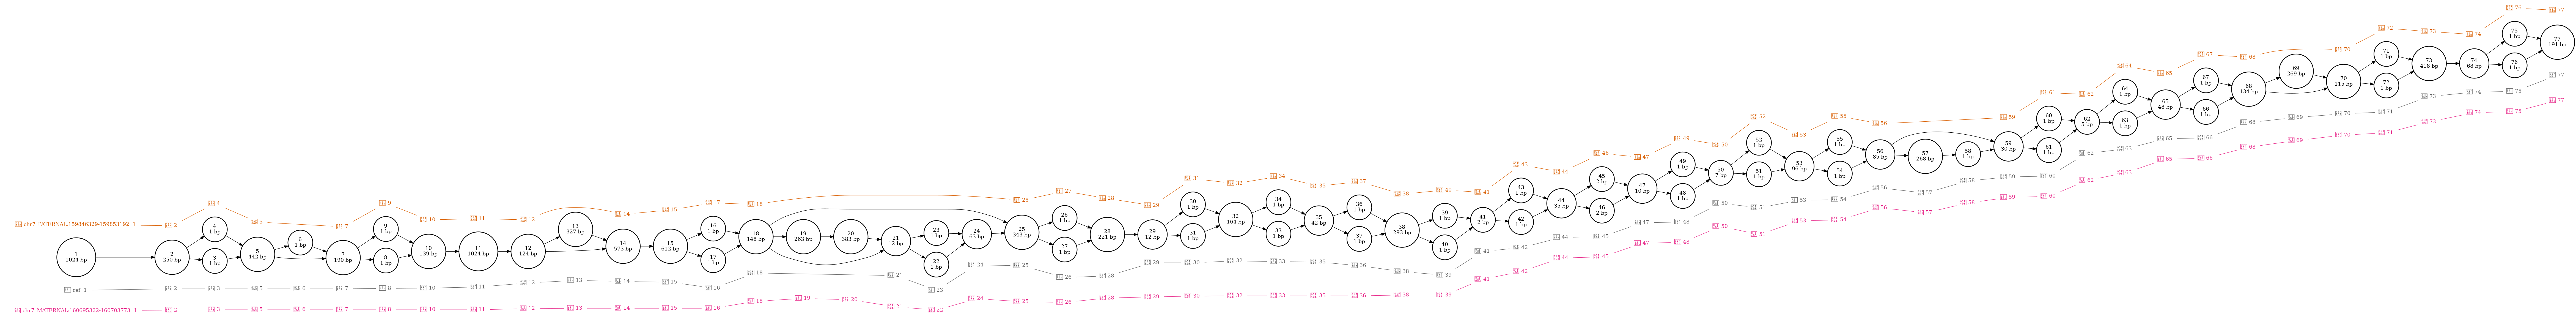

In [18]:
Image(filename='msa.png') 

The pangenome now also contains small variants, as visible by the small "bubbles". Feel free to open `msa.png` to have a better look.

### Optional. Visualize pangenome with odgi

When the pangenome contains a lot of variants, it is more difficult to visualize the larger variants. Also the path/haplotypes/assemblies are not very readable on the graphic above.

The visualization from [odgi](https://github.com/pangenome/odgi) is better shows the large variants and large differences between haplotypes.

In [19]:
!vg view msa.vg > msa.gfa
!odgi build -g msa.gfa -o /dev/stdout | odgi sort -i /dev/stdin -o msa.og
!odgi viz -i msa.og -o msa.og.png

To use odgi, we first convert the pangenome to the GFA format with `vg view`. We then build and sort a graph with odgi.
Finally, we use `odgi viz` to make the image.

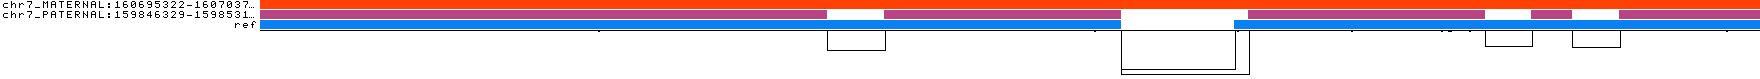

In [20]:
Image(filename='msa.og.png') 

### Genotype structural variants

We can then run the same commands as before to map reads and call variants

In [23]:
!vg gbwt -x msa.vg --gbz-format -g msa.gbz -E

!rm -f msa.min msa.dist
!vg giraffe -Z msa.gbz -i -f svgenotyping_data/reads.fastq.gz -o gaf | gzip > reads.msa.gaf.gz

!vg pack -x msa.gbz -o reads.msa.pack -a reads.msa.gaf.gz
!vg call -k reads.msa.pack -c 50 msa.vg -p ref > calls.msa.vcf

[IndexRegistry]: Constructing distance index for Giraffe.
[IndexRegistry]: Constructing minimizer index.
warning[vg::giraffe]: Finalizing fragment length distribution before reaching maximum sample size
                      mapped 461 reads single ended with 2597 pairs of reads left unmapped
                      mean: 0, stdev: 1
warning[vg::giraffe]: Cannot cluster reads with a fragment distance smaller than read distance
                      Fragment length distribution: mean=0, stdev=1
                      Fragment distance limit: 2, read distance limit: 201
warning[vg::giraffe]: Falling back on single-end mapping


The only differences are that:

- we can use the real haplotypes when mapping with giraffe (`-E` in the `vg gbwt` command means to use the embedded paths)
- we don't have "input" SVs to genotype anymore, so we genotype any snarls (~bubbles) larger than 50 bp (`-c 50` in the `vg call` command)

In [24]:
!cat calls.msa.vcf

##fileformat=VCFv4.2
##contig=<ID=ref,length=7806>
##INFO=<ID=AT,Number=R,Type=String,Description="Allele Traversal as path in graph">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Total Depth">
##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=MAD,Number=1,Type=Integer,Description="Minimum site allele depth">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">
##FORMAT=<ID=GL,Number=G,Type=Float,Description="Genotype Likelihood, log10-scaled likelihoods of the data given the called genotype for each possible genotype generated from the reference and alternate alleles given the sample ploidy">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality, the Phred-scaled probability estimate of the called genotype">
##FORMAT=<ID=GP,Number=1,Type=Float,Description="Genotype Probability, the log-scaled posterior probability of t

How did this approach work? Did we better genotype the SVs from the truthset? Or similar ones?

If the SVs are slightly different, why could that be?

### Optional: Visualize the read alignment with the sequenceTubeMap

1. Navigate to the sequenceTubeMap server (see [Workshop landing page](https://github.com/jmonlong/workshop-hprc-hugo24/blob/main/workshop-hprc-hugo24-landing.md)).
2. In the *Data:* menu, select *SV genotyping - construct* (for the reference + VCF pangenome) or *SV genotyping - MSA* (for the assembly-based pangenome).
3. In *Region:*, enter
   - `ref:2990+100` to jump around the first SV (deletion)
   - `ref:4800+100` to jump around the second SV (insertion)
4. Press *Go*

To manipulate the tubemap, you can:
- Hold-click to move horizontally
- Scroll to zoom in/out
- Change some visualization settings in the configuration panel below the graph.\

You should see something like this for the "construct" pangenome:
![](tubemap.construct.png)

This is the "compressed" view of the sequenceTubeMap where node size is not to scale (enable/disable in the *Legend* panel at the bottom). 
It's easier to get an overview of the SV support. 
Here we see the haplotypes in color ful paths first, with the reference in dark blue. The reads are the paths are the bottom in shades of blue and read (different strands).
We see the deletion on the left: the reference path (dark blue) goes through the node but some haplotypes don't. We don't see read support for it though, all reads follow the reference path.
On the right/middle, we see the insertion. The reference path doesn't include the node but some haplotypes (beige, pink) traverse the insertion node. We see read support for both the breakpoints and within the insertion.

For the MSA pangenome, the compressed view looks like this:

![](tubemap.msa.png)

This time, the reference path is in orange (hover over a path to display its name).
Here, we see a few reads supporting the deletion on the left.
We also see a slightly more complex insertion site on the right.
Building pangenomes through alignment of high-quality assemblies can better represent variation, both in terms of placement (e.g. the deletion) and representation (e.g. complex insertions).

